# Assignment 13.1 - Autoencoder (AE)

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf.

#### Please state both names of your group members here:
Farah Ahmed Atef Abdelhameed Hafez

## Task 13.1.1: AE

* Implement a basic Autoencoder model and training loop that has a bottleneck, i.e., smaller latent dimension size as input/out dimension size. **(RESULT)**
* Train the Autoencoder on the MNIST dataset. **(RESULT)**
* Visualize some original and reconstructed images from the test set. **(RESULT)**
* Visualize the embeddings ofa subset (10 samples) of the test samples using `t-SNE`. You should use your trained encoder model to create those embeddings. **(RESULT)**

In [134]:
from torch import nn, Tensor
import torch
import torchvision
import torchvision.transforms as T
import numpy as np



#Build Autoencoder

In [135]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super(Autoencoder, self).__init__()
        self.input_dim=input_dim

        self.encoder = nn.Sequential(nn.Linear(input_dim*input_dim, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, input_dim*input_dim), nn.Sigmoid())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded=decoded.view(-1, 1, self.input_dim, self.input_dim)
        return encoded, decoded

#Train and Test Logic

In [136]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    model.train()
    for i in range(epoch):
      totalloss=0
      for batch_x, batch_y in train_loader:
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)
          optimizer.zero_grad()
          encoded, decoded = model(batch_x)
          loss = criterion(decoded, batch_x)
          totalloss+=loss.item()
          loss.backward()
          optimizer.step()
      print("Epoch: ", i, "Average Training Loss: ", totalloss/len(train_loader))




customised the test logic to serve the visualisation tasks

In [137]:
def test(model, test_loader, device):
    model.eval()
    OriginalDecodedpairs=[]
    encodedrep=[]
    labels=[]
    totalloss=0
    classcount={}
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            encoded, decoded = model(batch_x)
            if len(classcount)<10 or any(count < 10 for count in classcount.values()):
              for i in range(len(batch_x)):
                myclass=batch_y[i].item()
                if myclass not in classcount:
                  classcount[myclass]=1
                  encodedrep.append(encoded[i].cpu().numpy())
                  labels.append(myclass)
                else:
                  if classcount[myclass]<10:
                    classcount[myclass]+=1
                    encodedrep.append(encoded[i].cpu().numpy())
                    labels.append(myclass)
                  else:
                    continue

            # decoded=decoded.view(-1, 1, 28, 28)
            loss=nn.functional.mse_loss(decoded, batch_x)
            totalloss+=loss.item()
            encoded=encoded.cpu().numpy()
            decoded=decoded.cpu().numpy()
            original=batch_x.cpu().numpy()
            OriginalDecodedpairs.append((original, decoded))
        encodedrep=np.array(encodedrep)
    return OriginalDecodedpairs, encodedrep, labels, totalloss/len(test_loader)





#Load dataset

In [138]:
transform = T.Compose([T.Resize(28),T.ToTensor()])

train_set = torchvision.datasets.MNIST(
  root="./../datasets", train=True, download=True, transform=transform
)
test_set = torchvision.datasets.MNIST(
  root="./../datasets", train=False, download=True, transform=transform
)

train_loader =  torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=32)
test_loader =  torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=32)


#Train

In [139]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(latent_dim=32, input_dim=28).to(device)
criterion= nn.MSELoss()
optimiser= torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, optimiser, criterion, 30, device)


Epoch:  0 Average Training Loss:  0.03741027143597603
Epoch:  1 Average Training Loss:  0.02048946155856053
Epoch:  2 Average Training Loss:  0.016293963059286275
Epoch:  3 Average Training Loss:  0.014170585544904073
Epoch:  4 Average Training Loss:  0.01264945004582405
Epoch:  5 Average Training Loss:  0.011511818094303211
Epoch:  6 Average Training Loss:  0.01065159001722932
Epoch:  7 Average Training Loss:  0.010030246027062336
Epoch:  8 Average Training Loss:  0.009482591634492079
Epoch:  9 Average Training Loss:  0.009077043445159992
Epoch:  10 Average Training Loss:  0.008750147494922082
Epoch:  11 Average Training Loss:  0.008449234382808209
Epoch:  12 Average Training Loss:  0.008200519472857316
Epoch:  13 Average Training Loss:  0.007990080641955137
Epoch:  14 Average Training Loss:  0.007796068353702624
Epoch:  15 Average Training Loss:  0.007626288037747145
Epoch:  16 Average Training Loss:  0.007464156341304382
Epoch:  17 Average Training Loss:  0.007318778048455715
Epoch:

#Test

In [140]:
import matplotlib.pyplot as plt
test_originalDecodedpairs, encodedrep, classes, test_loss=test(model, test_loader, device)

print("Test Loss of autoencoder: ", test_loss)


Test Loss of autoencoder:  0.0061183495911213154


#Visualise original vs reconstructed

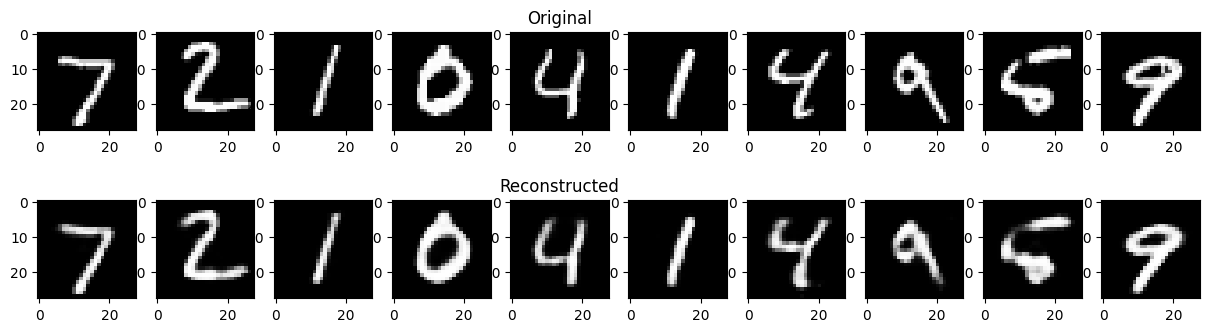

In [141]:
original, decoded = test_originalDecodedpairs[0]
plt.figure(figsize=(15, 4))
n=10
for i in range(10):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].squeeze(), cmap="gray")
    if i == 4:
        plt.title("Original")
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i].squeeze(), cmap="gray")
    if i == 4:
        plt.title("Reconstructed")
plt.show()

# Visualise embeddings

In [142]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=20,random_state=42)
encoded_2d = tsne.fit_transform(encodedrep)

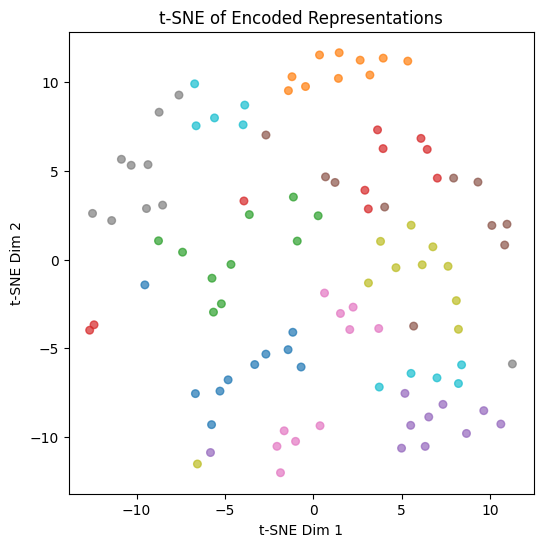

In [143]:
plt.figure(figsize=(6, 6))
plt.scatter(encoded_2d[:, 0],encoded_2d[:, 1],c=classes,cmap="tab10",s=30, alpha=0.7)
plt.title("t-SNE of Encoded Representations")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


You can see same classes are mostly close together indicating good performance given this basic autoencoder

## Task 13.1.2: VAE (BONUS)

* Implement a Variational Autoencoder model and training loop. Ideally you implement it close to the original using the reparametrization trick. **(RESULT)**
* Train the Variational Autoencoder on the MNIST dataset. **(RESULT)**
* Visualize some original and reconstructed images from the test set. **(RESULT)**
* Sample 10 synthetic images from the learned latent space by sampling from the prior distribution and passing the samples through the decoder. **(RESULT)**

In [144]:
# TODO: Implement

## Congratz, you made it! :)